# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Заказчик этого исследования — сеть отелей «Как в гостях».

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

### Шаг 1. Откройте файлы с данными

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import math
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score
from time import strptime
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix

In [2]:
hotel_train = pd.read_csv('/datasets/hotel_train.csv')
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [3]:
display(hotel_train.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


In [4]:
display(hotel_train.tail())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
65224,84057,0,23.0,2016,December,53,30,2,4,2.0,...,0,0,0,D,0,0,Transient,0,2,6
65225,84063,0,53.0,2016,December,53,31,2,3,2.0,...,0,0,0,D,0,0,Transient,0,3,5
65226,84094,0,7.0,2016,December,53,31,2,4,2.0,...,0,0,0,D,0,0,Transient,0,1,6
65227,84117,0,17.0,2016,December,53,30,2,5,2.0,...,0,0,0,A,0,0,Transient,0,1,7
65228,84121,0,107.0,2016,December,53,31,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


In [5]:
hotel_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,65229.0,NaN,NaN,NaN,43544.069172,25614.858971,0.0,19108.0,40554.0,67414.0,84121.0
is_canceled,65229.0,NaN,NaN,NaN,0.368609,0.482431,0.0,0.0,0.0,1.0,1.0
lead_time,65229.0,NaN,NaN,NaN,96.337917,96.127545,0.0,17.0,64.0,151.0,374.0
arrival_date_year,65229.0,NaN,NaN,NaN,2015.719021,0.449481,2015.0,2015.0,2016.0,2016.0,2016.0
arrival_date_month,65229,12,October,9255,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_week_number,65229.0,NaN,NaN,NaN,31.339772,13.464024,1.0,21.0,34.0,42.0,53.0
arrival_date_day_of_month,65229.0,NaN,NaN,NaN,15.847813,8.748182,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,65229.0,NaN,NaN,NaN,0.825185,0.853477,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,65229.0,NaN,NaN,NaN,2.224793,1.354992,0.0,1.0,2.0,3.0,6.0
adults,65229.0,NaN,NaN,NaN,1.836576,0.480245,0.0,2.0,2.0,2.0,4.0


In [6]:
hotel_test = pd.read_csv('/datasets/hotel_test.csv')
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

In [7]:
hotel_test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,32412.0,60131.505183,29953.586177,6086.0,45291.75,53394.5,89800.25,97903.0
is_canceled,32412.0,0.388467,0.487409,0.0,0.00,0.0,1.00,1.0
lead_time,32412.0,97.587869,86.507146,0.0,23.00,76.0,155.00,373.0
arrival_date_year,32412.0,2017.000000,0.000000,2017.0,2017.00,2017.0,2017.00,2017.0
arrival_date_week_number,32412.0,17.804054,9.177384,1.0,10.00,18.0,25.00,35.0
arrival_date_day_of_month,32412.0,15.656948,8.766429,1.0,8.00,15.5,23.00,31.0
stays_in_weekend_nights,32412.0,0.867888,0.853394,0.0,0.00,1.0,2.00,4.0
stays_in_week_nights,32412.0,2.340090,1.375170,0.0,1.00,2.0,3.00,6.0
adults,32412.0,1.858602,0.489341,0.0,2.00,2.0,2.00,4.0
children,32412.0,0.083765,0.343470,0.0,0.00,0.0,0.00,3.0


Описание данных:

В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:

- id — номер записи;
- adults — количество взрослых постояльцев;
- arrival_date_year — год заезда;
- arrival_date_month — месяц заезда;
- arrival_date_week_number — неделя заезда;
- arrival_date_day_of_month — день заезда;
- babies — количество младенцев;
- booking_changes — количество изменений параметров заказа;
- children — количество детей от 3 до 14 лет;
- country — гражданство постояльца;
- customer_type — тип заказчика:
- Contract — договор с юридическим лицом;
- Group — групповой заезд;
- Transient — не связано с договором или групповым заездом;
- Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- days_in_waiting_list — сколько дней заказ ожидал подтверждения;
- distribution_channel — канал дистрибуции заказа;
- is_canceled — отмена заказа;
- is_repeated_guest — признак того, что гость бронирует номер второй раз;
- lead_time — количество дней между датой бронирования и датой прибытия;
- meal — опции заказа:
- previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
- previous_cancellations — количество отменённых заказов у клиента;
- required_car_parking_spaces — необходимость места для автомобиля;
- reserved_room_type — тип забронированной комнаты;
- stays_in_weekend_nights — количество ночей в выходные дни;
- stays_in_week_nights — количество ночей в будние дни;
- total_nights — общее количество ночей;
- total_of_special_requests — количество специальных отметок.

#### Вывод
 
Мы импортировали и изучили страктуру тренировочного и тестового датасета. Предварительно можно утверждать, что в данных нет пропусков, однако необходимо проверить категориальные значения, а также провести проверку на дубликаты

В тренировочной выборке обнаружены аномалии, например, количество младенцев - 10

### Шаг 2. Предобработка и исследовательский анализ данных

In [8]:
#hotel_train['arrival_date_month'].unique()
hotel_train['arrival_date_month'].value_counts(normalize=True)

October      0.141885
September    0.134633
August       0.102378
November     0.088320
July         0.087660
December     0.084272
April        0.073648
May          0.071701
June         0.071425
March        0.063591
February     0.051480
January      0.029006
Name: arrival_date_month, dtype: float64

In [9]:
hotel_train['arrival_date_month'] = hotel_train['arrival_date_month'].apply(lambda x: strptime(x,'%B').tm_mon) 
hotel_test['arrival_date_month'] = hotel_test['arrival_date_month'].apply(lambda x: strptime(x,'%B').tm_mon) 

In [10]:
hotel_train['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

Столбец с категорией не имеет неявных дубликатов, однако каждая запись имеет пробелы, такой формат записи может доставить много проблем, поэтому ниже избавимся от пробелов

In [11]:
hotel_test['country'].unique()

array(['PRT', 'AUT', 'BEL', 'DEU', 'BRA', 'GBR', 'ESP', 'FRA', 'ITA',
       'LUX', 'CHE', 'EST', 'NGA', 'IRL', 'CN', 'POL', 'AUS', 'NLD',
       'KOR', 'ROU', 'USA', 'CHL', 'DNK', 'FIN', 'RUS', 'SWE', 'HUN',
       'HRV', 'MDV', 'ZAF', 'ISR', 'NOR', 'CHN', 'ARE', 'MAR', 'COL',
       'FJI', 'LVA', 'LBN', 'PHL', 'HKG', 'SYC', 'GIB', 'AGO', 'MYS',
       'MDG', 'IDN', 'LTU', 'ISL', 'TUR', 'ARG', 'JPN', 'SVN', 'SVK',
       'BGR', 'CAF', 'JAM', 'UZB', 'UKR', 'IND', 'CZE', 'URY', 'NZL',
       'NPL', 'SRB', 'CPV', 'IRN', 'KAZ', 'BHS', 'SUR', 'CUB', 'PAK',
       'MAC', 'CYP', 'JOR', 'GRC', 'KWT', 'TWN', 'VNM', 'SGP', 'DOM',
       'VEN', 'SEN', 'BLR', 'TZA', 'LIE', 'GNB', 'SAU', 'DZA', 'PER',
       'AZE', 'EGY', 'ETH', 'KEN', 'THA', 'MLT', 'ECU', 'AND', 'IMN',
       'BHR', 'TUN', 'MNE', 'MEX', 'BEN', 'MOZ', 'UMI', 'JEY', 'MYT',
       'QAT', 'BGD', 'GAB', 'CIV', 'ZWE', 'GTM', 'ALB', 'GHA', 'ATA',
       'ASM', 'PAN', 'CRI', 'MCO', 'MUS', 'SYR', 'TGO', 'IRQ', 'LKA',
       'BIH', 'PRY', 

In [12]:
hotel_train['country'].unique()

array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU',
       'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL',
       'EST', 'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA',
       'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT',
       'LTU', 'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA',
       'KOR', 'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB',
       'JEY', 'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA',
       'DOM', 'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS',
       'BIH', 'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR',
       'SYR', 'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE',
       'PLW', 'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP',
       'TWN', 'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ',
       'AND', 'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD',
       'ISL', 'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA',
       'GAB', 'MKD', 

Очень много категориальных значений, к тому же списки не равны, при выполнении уанхота появятся лишние признаки. Поэтому я предлагаю провести категоризацию по регионам в классификации ООН

In [13]:
af = ['Africa']
country = pd.read_csv('https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv')
country = country.drop(['name', 'alpha-2', 'country-code','iso_3166-2', 'region', 'intermediate-region', 'region-code',
                       'sub-region-code', 'intermediate-region-code'], axis=1)

def africa(item):
    if item == 'Polynesia' or item == 'Northern Africa':
        item = 'Africa'
    return item

def oceania(item):
    if item == 'Sub-Saharan Africa' or item == 'Micronesia' or item == 'Melanesia':
        item = 'Oceania'
    return item


country.rename(columns = {'alpha-3' : 'country', 'sub-region' : 'region'}, inplace = True)
country['region']=country.apply(lambda x:africa(x.region), axis=1)
country['region']=country.apply(lambda x:oceania(x.region), axis=1)

country.rename(columns = {'alpha-3' : 'country'}, inplace = True)
display(country.head())

,country,region
0,AFG,Southern Asia
1,ALA,Northern Europe
2,ALB,Southern Europe
3,DZA,Africa
4,ASM,Africa


In [14]:
hotel_train = hotel_train.merge(country[['country','region']],on='country',how='inner')

In [15]:
hotel_train['region']=hotel_train['region'].fillna('unknown')
hotel_train['region'].unique()

array(['Northern Europe', 'Southern Europe', 'Western Europe',
       'Eastern Europe', 'Northern America',
       'Latin America and the Caribbean', 'Oceania', 'Eastern Asia',
       'Africa', 'Western Asia', 'Southern Asia',
       'Australia and New Zealand', 'Central Asia', 'South-eastern Asia',
       'unknown'], dtype=object)

In [16]:
hotel_test = hotel_test.merge(country[['country','region']],on='country',how='inner')

In [17]:
hotel_test['region']=hotel_test['region'].fillna('unknown')


In [18]:
hotel_train['distribution_channel'].unique()

array(['Direct', 'TA/TO', 'Corporate', 'GDS'], dtype=object)

In [19]:
hotel_train['reserved_room_type']=hotel_train['reserved_room_type'].str.strip()
hotel_test['reserved_room_type']=hotel_test['reserved_room_type'].str.strip()
hotel_test['meal']=hotel_test['meal'].str.strip()
hotel_train['meal']=hotel_train['meal'].str.strip()

In [20]:
key = ['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 
       'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
      'babies', 'meal', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 
       'previous_bookings_not_canceled', 'reserved_room_type', 'booking_changes', 'days_in_waiting_list', 
      'customer_type', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights', 'country', 'region']
hotel_train = hotel_train.drop_duplicates(subset=key).reset_index(drop= True)
hotel_test = hotel_test.drop_duplicates(subset=key).reset_index(drop= True)
print(hotel_train.shape)
print(hotel_test.shape)

(43441, 26)
(24290, 26)


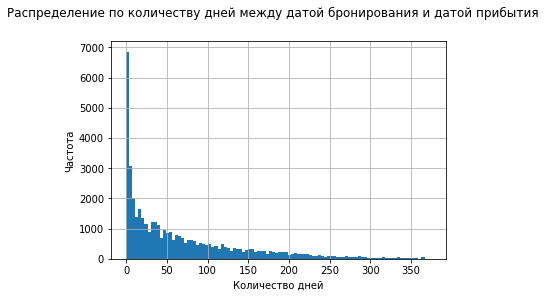

In [21]:
hotel_train['lead_time'].hist(bins=100)
plt.suptitle('Распределение по количеству дней между датой бронирования и датой прибытия', size=12, y=1.0); 
plt.xlabel("Количество дней")
plt.ylabel("Частота")
plt.show()

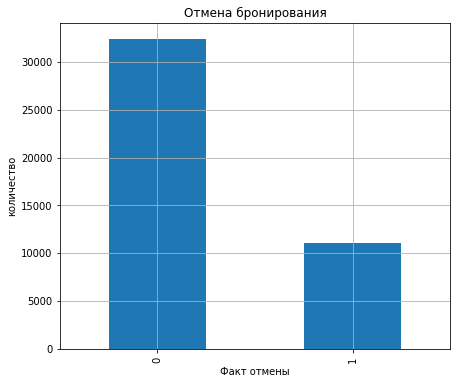

In [22]:
hotel_train['is_canceled'].value_counts().plot(kind='bar',grid=True,figsize=(7,6),title='Отмена бронирования')
plt.xlabel("Факт отмены")
plt.ylabel("количество")
plt.show()

Подсчитаем коэфициент:

In [23]:
imbalance_coef  = math.ceil(hotel_train.query("is_canceled == 0")['is_canceled'].count()/hotel_train.query("is_canceled == 1")['is_canceled'].count())

In [24]:
print(f"Количество неотмененных бронирований больше количества отмен в {imbalance_coef} раз")

Количество неотмененных бронирований больше количества отмен в 3 раз


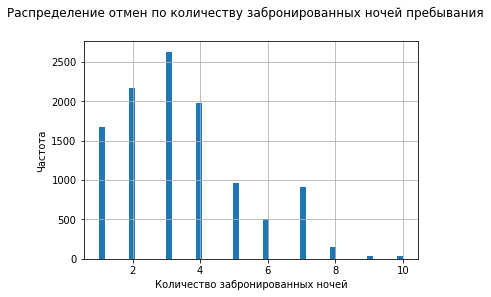

In [25]:
hotel_train.query('is_canceled==1')['total_nights'].hist(bins=50)
plt.suptitle('Распределение отмен по количеству забронированных ночей пребывания', size=12, y=1.0); 
plt.xlabel("Количество забронированных ночей")
plt.ylabel("Частота")
plt.show()

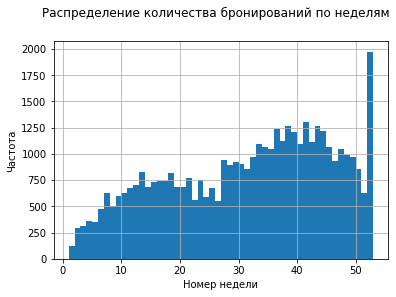

In [26]:
hotel_train['arrival_date_week_number'].hist(bins=52)
plt.suptitle('Распределение количества бронирований по неделям', size=12, y=1.0); 
plt.xlabel("Номер недели")
plt.ylabel("Частота")
plt.show()

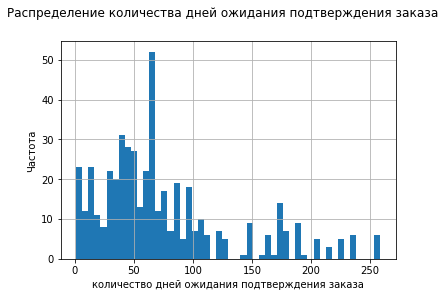

In [27]:
hotel_train.query('days_in_waiting_list>0')['days_in_waiting_list'].hist(bins=50)
plt.suptitle('Распределение количества дней ожидания подтверждения заказа', size=12, y=1.0); 
plt.xlabel("количество дней ожидания подтверждения заказа")
plt.ylabel("Частота")
plt.show()

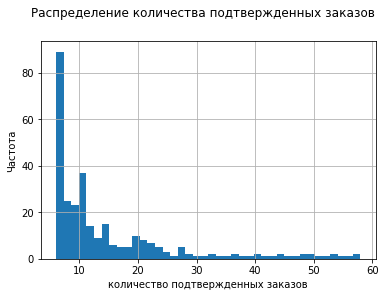

In [28]:

hotel_train.query('previous_bookings_not_canceled>5')['previous_bookings_not_canceled'].hist(bins=40)
plt.suptitle('Распределение количества подтвержденных заказов', size=12, y=1.0); 
plt.xlabel("количество подтвержденных заказов")
plt.ylabel("Частота")
plt.show()

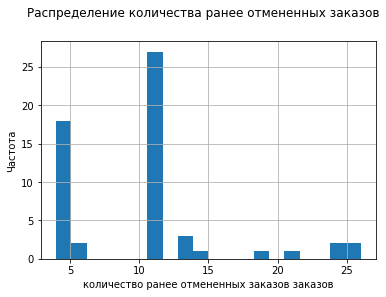

In [29]:
hotel_train.query('previous_cancellations>3')['previous_cancellations'].hist(bins=20)
plt.suptitle('Распределение количества ранее отмененных заказов', size=12, y=1.0); 
plt.xlabel("количество ранее отмененных заказов заказов")
plt.ylabel("Частота")
plt.show()


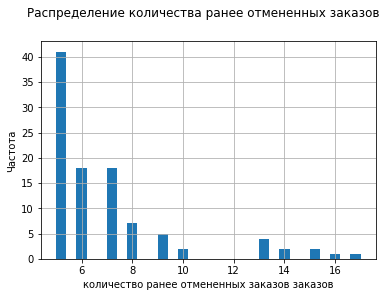

In [30]:
hotel_train.query('booking_changes >4')['booking_changes'].hist(bins=30)
plt.suptitle('Распределение количества ранее отмененных заказов', size=12, y=1.0); 
plt.xlabel("количество ранее отмененных заказов заказов")
plt.ylabel("Частота")
plt.show()

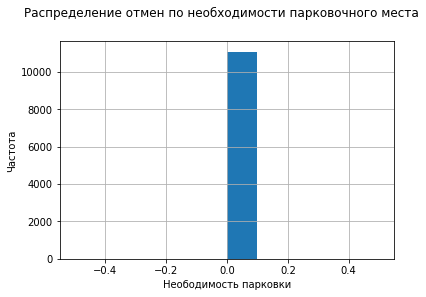

In [31]:
hotel_train.query('is_canceled==1')['required_car_parking_spaces'].hist(bins=10)
plt.suptitle('Распределение отмен по необходимости парковочного места', size=12, y=1.0); 
plt.xlabel("Неободимость парковки")
plt.ylabel("Частота")
plt.show()

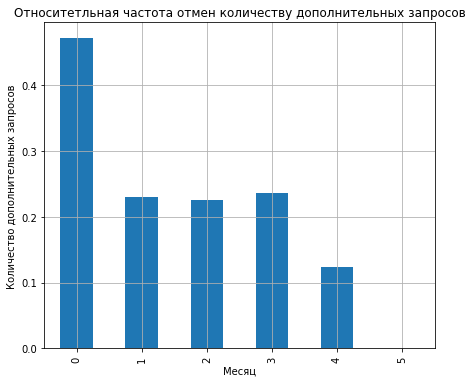

In [32]:

cancel_rate_first_period = hotel_train.query('is_canceled==1')['total_of_special_requests'].value_counts()/hotel_train.query('is_canceled==0')['total_of_special_requests'].value_counts()
fig, ax = plt.subplots()
cancel_rate_first_period.plot(kind='bar',grid=True,figsize=(7,6),title='Относитетльная частота отмен количеству дополнительных запросов')
plt.xlabel("Месяц")
plt.ylabel("Количество дополнительных запросов")
plt.show()



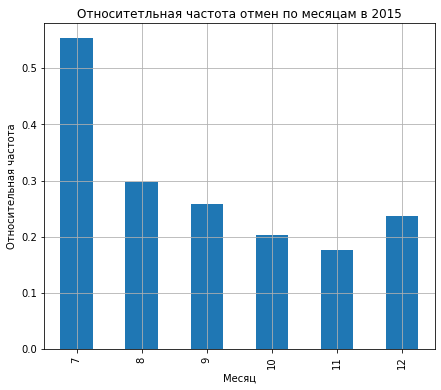

In [33]:
cancel_rate_first_period = hotel_train.query('arrival_date_year == 2015 and is_canceled==1')['arrival_date_month'].value_counts()/hotel_train.query('arrival_date_year == 2015 and is_canceled==0')['arrival_date_month'].value_counts()
fig, ax = plt.subplots()
cancel_rate_first_period.plot(kind='bar',grid=True,figsize=(7,6),title='Относитетльная частота отмен по месяцам в 2015')
plt.xlabel("Месяц")
plt.ylabel("Относительная частота")
plt.show()




За 2015 год имеем данные только за пол года. Из графика видно, какая часть бронирований были отменены.

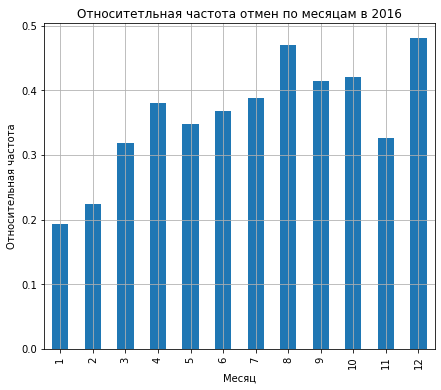

In [34]:
cancel_rate_second_period = hotel_train.query('arrival_date_year == 2016 and is_canceled==1')['arrival_date_month'].value_counts()/hotel_train.query('arrival_date_year == 2016 and is_canceled==0')['arrival_date_month'].value_counts()
fig, ax = plt.subplots()
cancel_rate_second_period.plot(kind='bar',grid=True,figsize=(7,6),title='Относитетльная частота отмен по месяцам в 2016')
plt.xlabel("Месяц")
plt.ylabel("Относительная частота")
plt.show()


За 2016 год мы имеем данные за все 12 месяцев, поэтому оценить прибыль без использования модели мы можем именно за этот период

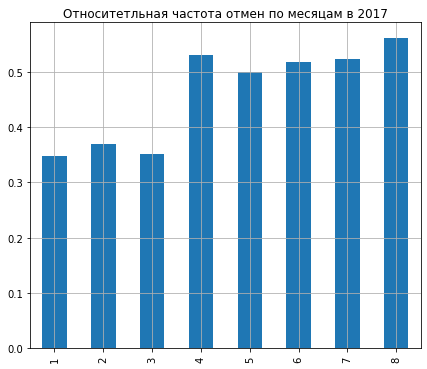

In [35]:
cancel_rate_third_period = hotel_test.query('arrival_date_year == 2017 and is_canceled==1')['arrival_date_month'].value_counts()/hotel_test.query('arrival_date_year == 2017 and is_canceled==0')['arrival_date_month'].value_counts()
fig, ax = plt.subplots()
cancel_rate_third_period.plot(kind='bar',grid=True,figsize=(7,6),title='Относитетльная частота отмен по месяцам в 2017')
plt.show()

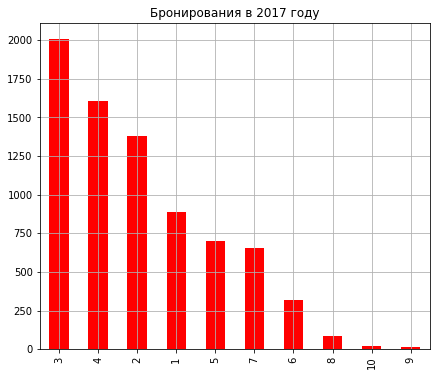

In [36]:
fig, ax = plt.subplots()
hotel_test.query('is_canceled==1')['total_nights'].value_counts().plot(kind='bar',
                                                                                         grid=True,figsize=(7,6),
                                                                                         title='Бронирования в 2017 году', 
                                                                                         ax=ax, facecolor='r')
plt.show()

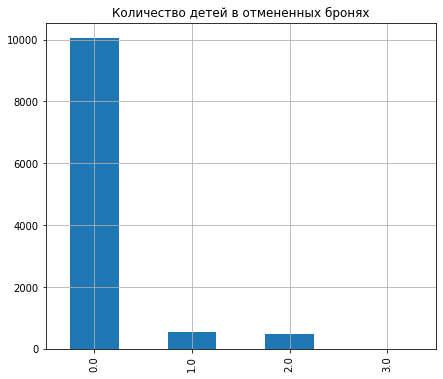

In [37]:
fig, ax = plt.subplots()
hotel_train.query('is_canceled==1')['children'].value_counts().plot(kind='bar',
                                                                                         grid=True,figsize=(7,6),
                                                                                         title='Количество детей в отмененных бронях', 
                                                                                         ax=ax)
plt.show()

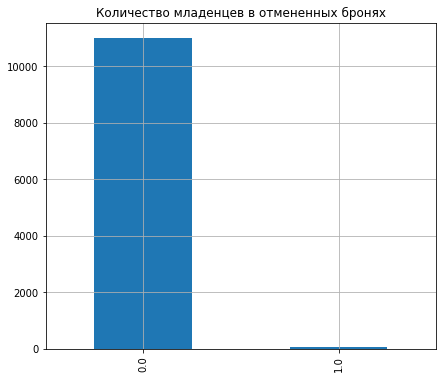

In [38]:
fig, ax = plt.subplots()
hotel_train.query('is_canceled==1')['babies'].value_counts().plot(kind='bar',
                                                                                         grid=True,figsize=(7,6),
                                                                                         title='Количество младенцев в отмененных бронях', 
                                                                                         ax=ax)
plt.show()

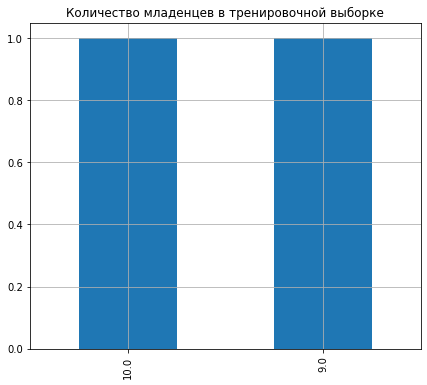

In [39]:
fig, ax = plt.subplots()
hotel_train.query('babies >2')['babies'].value_counts().plot(kind='bar',
                                                                                         grid=True,figsize=(7,6),
                                                                                         title='Количество младенцев в тренировочной выборке', 
                                                                                         ax=ax)
plt.show()

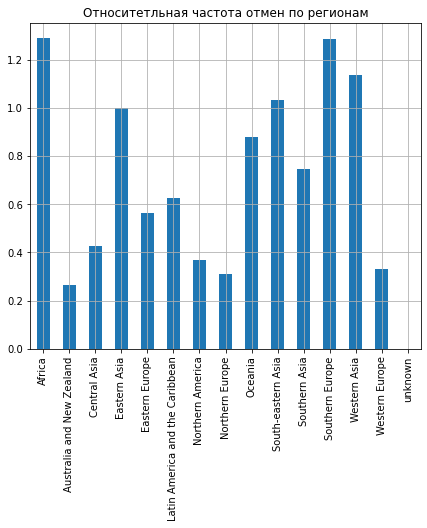

In [40]:
cancel_rate_region = hotel_train.query('is_canceled==1')['region'].value_counts()/hotel_test.query('is_canceled==0')['region'].value_counts()
fig, ax = plt.subplots()
cancel_rate_region.plot(kind='bar',grid=True,figsize=(7,6),title='Относитетльная частота отмен по регионам')
plt.show()


В тестовом датасете данные за 2017 год, но только до августа

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Создадим словарь со стоимостью номеров и их обслуживания в зависимости от категории, и посчитаем стоимость каждого отдельного бронирования, с учетом сезонного повышения цен

In [41]:
category = {'A':[1000,400], 'B':[800,350],
           'C':[600,350], 'D':[550, 150],
           'E':[500,150], 'F':[450,150],
           'G':[350,150]}

In [42]:
hotel_train_revenue = hotel_train.copy(deep=True)
hotel_test_revenue = hotel_test.copy(deep=True)

In [43]:
def season(row):
    summer = [6, 7, 8]
    autumn = [9, 10, 11,  3, 4, 5]
    month = row['arrival_date_month']
    if month in summer:
        return 1.4
    elif month in autumn:
        return 1.2
    else:
        return 1.0

hotel_train_revenue['season_margin']=hotel_train_revenue.apply(season, axis=1)
hotel_test_revenue['season_margin']=hotel_test_revenue.apply(season, axis=1)

In [44]:
def revenue(row):
    price = [value[0] for key, value in category.items() if key == row['reserved_room_type']]
    expense = [value[1] for key, value in category.items() if key == row['reserved_room_type']]
    cancel = row['is_canceled']
    total_nights = row['total_nights']
    season = row['season_margin']
    if cancel == 0:
        revenue =  int(''.join(map(str, price)))*total_nights*season - int(''.join(map(str, expense)))*math.ceil(total_nights/2)
    else:
        revenue = -int(''.join(map(str, expense)))
        
    return revenue

hotel_train_revenue['revenue'] = hotel_train_revenue.apply(revenue, axis=1) 
hotel_test_revenue['revenue'] = hotel_test_revenue.apply(revenue, axis=1) 

In [45]:
revenue_train_set = hotel_train_revenue.groupby(['arrival_date_year']).agg({'revenue': 'sum'})
display(revenue_train_set)

,revenue
arrival_date_year,
2015,21148750.0
2016,60305040.0


Проверим выручку в 2016 году за месяцы с января по август

In [46]:
revenue_train_set = hotel_train_revenue.query("arrival_date_year== 2016 and arrival_date_month in (1,2,3,4,5,6,7,8)").groupby(['arrival_date_year']).agg({'revenue': 'sum'})
display(revenue_train_set)

,revenue
arrival_date_year,
2016,41222130.0


In [47]:
revenue_test_set = hotel_test_revenue.groupby(['arrival_date_year']).agg({'revenue': 'sum'})
display(revenue_test_set)

,revenue
arrival_date_year,
2017,42163160.0


#### Вывод

Если говорить о выручке за полный год, то мы имеем данные только для 2016 года - в том году выручка составила 60.3 млн руб. Однако если сравнить выручку по имеющимся данным за 2017 год и аналогичный период 2016 года, то выручка составит 42.1 млн руб и 41.2 млн руб, соответственно

### Шаг 4. Разработка модели ML

Проверим размер тренировочной выборки

In [48]:
hotel_train.shape

(43441, 26)

Проверим размер тестовой выборки

In [49]:
hotel_test.shape

(24290, 26)

Избавимся от ненужных столбцов, разобьем данные на тренировочные и валидационные выборки, сделаем уанхот и проскалируем числовые признаки.

In [50]:
hotel_train_region = hotel_train.drop(['country','id'], axis=1)
hotel_test_region = hotel_test.drop(['country','id'], axis=1)

hotel_train_ohe=pd.get_dummies(hotel_train_region,drop_first=True)
hotel_test_ohe=pd.get_dummies(hotel_test_region,drop_first=True)
print(hotel_train_ohe.shape)
print(hotel_test_ohe.shape)

(43441, 48)
(24290, 48)


In [51]:
features = hotel_train_ohe.drop(['is_canceled', 'arrival_date_year'], axis=1)
features_test = hotel_test_ohe.drop(['is_canceled', 'arrival_date_year'], axis=1)
target = hotel_train_ohe['is_canceled']
target_test = hotel_test_ohe['is_canceled']

In [52]:
features.shape

(43441, 46)

In [53]:
features_test.shape

(24290, 46)

In [54]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                              test_size=0.3, 
                                                                              random_state=12345)

In [55]:
numeric = ['lead_time', 'arrival_date_week_number', 'stays_in_weekend_nights', 'arrival_date_day_of_month',
           'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 
          'booking_changes', 'days_in_waiting_list', 'total_of_special_requests', 'total_nights', 'arrival_date_month']

In [56]:
scaler = MinMaxScaler()
scaler.fit(features_train[numeric])

MinMaxScaler()

In [57]:
features_train_scaled = features_train.copy(deep=True)
features_train_scaled[numeric] = scaler.transform(features_train[numeric])

features_valid_scaled = features_valid.copy(deep=True)
features_valid_scaled[numeric] = scaler.transform(features_valid[numeric])

features_test_scaled = features_test.copy(deep=True)
features_test_scaled[numeric] = scaler.transform(features_test[numeric])

#### Logistic Regression

In [58]:
model_LR = LogisticRegression(solver='liblinear', random_state=12345, penalty = 'l1')
scores = cross_val_score(model_LR, features_train_scaled, target_train, cv=10, scoring='f1')
print('Cross-Validation Accuracy Scores', scores)
scores = pd.Series(scores)
scores.min(), scores.mean(), scores.max()

Cross-Validation Accuracy Scores [0.46206897 0.46023689 0.46727423 0.43266725 0.4560205  0.47208122
 0.4639444  0.46075085 0.44082333 0.44482464]


(0.4326672458731538, 0.45606922587143506, 0.4720812182741117)

#### Random Forest 

In [59]:
model_RF = RandomForestClassifier()
param_grid = { 
    'n_estimators': [10, 20, 30, 40, 50],
    'max_depth' : [5,7,9,11,13,15]
}

CV_model_RF = GridSearchCV(estimator=model_RF, param_grid=param_grid, cv=5)
CV_model_RF.fit(features_train_scaled, target_train)

predictions = CV_model_RF.best_estimator_.predict(features_valid_scaled)
print(CV_model_RF.best_estimator_)

print("F1:", f1_score(predictions, target_valid))

RandomForestClassifier(max_depth=15, n_estimators=40)
F1: 0.540321021079095


Модель случайного леса показывает лучшие результаты, попробуем работать именно с этой моделью.

#### Борьба с дисбалансом

In [60]:
model_RF_balanced = RandomForestClassifier(class_weight = 'balanced', max_depth=15, random_state=12345, n_estimators=20)
model_RF_balanced.fit(features_train_scaled, target_train)
scores = cross_val_score(model_RF_balanced, features_train_scaled, target_train, cv=10, scoring='f1')
print('Cross-Validation Accuracy Scores', scores)
scores = pd.Series(scores)
print('Максимальное значение f1 модели со взвешиванием - ', scores.max())

Cross-Validation Accuracy Scores [0.65292096 0.61653272 0.6221224  0.62729358 0.63477772 0.62421831
 0.65345413 0.62457338 0.62343572 0.61342207]
Максимальное значение f1 модели со взвешиванием -  0.653454133635334


##### Upsampling

Так как в тренажере нет библиотеки imblearn, кросс-валидацию будем делать вручную

In [61]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [62]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [63]:
features_upsampled_train, target_upsampled_train = upsample(features_train_scaled, target_train, imbalance_coef)

In [64]:
def score_model(model, params, cv=None):
    if cv is None:
        cv = KFold(n_splits=5, random_state=42)
    scores = []

    for train_fold_index, val_fold_index in cv.split(features_train_scaled, target_train):
        X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(features_train_scaled, target_train, 
                                                                              test_size=0.4, 
                                                                              random_state=12345)
        
        
        

        X_train_fold_upsample, y_train_fold_upsample = upsample(X_train_fold, y_train_fold, imbalance_coef)
        model_obj = model(**params).fit(X_train_fold_upsample, y_train_fold_upsample)
        score = f1_score(model_obj.predict(X_val_fold), y_val_fold)
        scores.append(score)
    return np.array(scores)

In [65]:
score_tracker = []
for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        example_params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'random_state': 12345
        }
        example_params['f1'] = score_model(RandomForestClassifier, 
                                               example_params, cv=kf).mean()
        score_tracker.append(example_params)

In [66]:
sorted(score_tracker, key=lambda x: x['f1'], reverse=True)

[{'n_estimators': 50,
  'max_depth': 15,
  'random_state': 12345,
  'f1': 0.6324264297612437},
 {'n_estimators': 30,
  'max_depth': 15,
  'random_state': 12345,
  'f1': 0.6297424536139573},
 {'n_estimators': 40,
  'max_depth': 15,
  'random_state': 12345,
  'f1': 0.6292791539103814},
 {'n_estimators': 30,
  'max_depth': 13,
  'random_state': 12345,
  'f1': 0.6255244282040873},
 {'n_estimators': 50,
  'max_depth': 13,
  'random_state': 12345,
  'f1': 0.6254752851711026},
 {'n_estimators': 20,
  'max_depth': 15,
  'random_state': 12345,
  'f1': 0.6241174027412432},
 {'n_estimators': 40,
  'max_depth': 13,
  'random_state': 12345,
  'f1': 0.623917748917749},
 {'n_estimators': 20,
  'max_depth': 13,
  'random_state': 12345,
  'f1': 0.6230487308266595},
 {'n_estimators': 10,
  'max_depth': 15,
  'random_state': 12345,
  'f1': 0.6179608372721135},
 {'n_estimators': 40,
  'max_depth': 11,
  'random_state': 12345,
  'f1': 0.6175740958349653},
 {'n_estimators': 50,
  'max_depth': 11,
  'random_

In [67]:
model_rf_upsc = RandomForestClassifier(n_estimators=50, max_depth=15, random_state=12345)
model_rf_upsc.fit(features_upsampled_train, target_upsampled_train)
f1_score(target_valid, model_rf_upsc.predict(features_valid_scaled))

0.6299172501591344

In [68]:
probabilities_valid = model_rf_upsc.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.8523196182046342


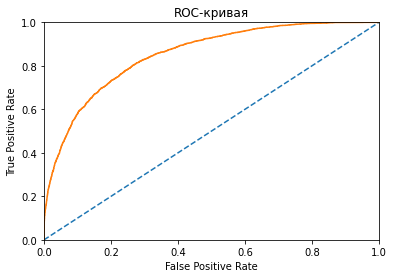

In [69]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

##### Downsampling

In [70]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [71]:
features_downsampled_train, target_downsampled_train = downsample(features_train_scaled, target_train, 1/imbalance_coef)

In [72]:
def score_model_downsampled(model, params, cv=None):
    if cv is None:
        cv = KFold(n_splits=5, random_state=42)
    scores = []

    for train_fold_index, val_fold_index in cv.split(features_train_scaled, target_train):
        X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(features_train_scaled, target_train, 
                                                                              test_size=0.4, 
                                                                              random_state=12345)
        
        
        

        X_train_fold_downsample, y_train_fold_downsample = downsample(X_train_fold, y_train_fold, 1/imbalance_coef)
        model_obj = model(**params).fit(X_train_fold_downsample, y_train_fold_downsample)
        score = f1_score(model_obj.predict(X_val_fold), y_val_fold)
        scores.append(score)
    return np.array(scores)

In [73]:
score_tracker_downsampled = []
for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        example_params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'random_state': 12345
        }
        example_params['f1'] = score_model_downsampled(RandomForestClassifier,example_params, cv=kf).mean()
        score_tracker_downsampled.append(example_params)

In [74]:
sorted(score_tracker_downsampled, key=lambda x: x['f1'], reverse=True)

[{'n_estimators': 50,
  'max_depth': 15,
  'random_state': 12345,
  'f1': 0.6231469440832249},
 {'n_estimators': 40,
  'max_depth': 13,
  'random_state': 12345,
  'f1': 0.6231077759089144},
 {'n_estimators': 50,
  'max_depth': 13,
  'random_state': 12345,
  'f1': 0.6219512195121951},
 {'n_estimators': 40,
  'max_depth': 15,
  'random_state': 12345,
  'f1': 0.6212357217030114},
 {'n_estimators': 30,
  'max_depth': 15,
  'random_state': 12345,
  'f1': 0.6184261532497739},
 {'n_estimators': 40,
  'max_depth': 11,
  'random_state': 12345,
  'f1': 0.6171147880041365},
 {'n_estimators': 30,
  'max_depth': 13,
  'random_state': 12345,
  'f1': 0.6158820486290739},
 {'n_estimators': 50,
  'max_depth': 11,
  'random_state': 12345,
  'f1': 0.6157800051400668},
 {'n_estimators': 30,
  'max_depth': 11,
  'random_state': 12345,
  'f1': 0.6141487431977196},
 {'n_estimators': 20,
  'max_depth': 15,
  'random_state': 12345,
  'f1': 0.6121815595499805},
 {'n_estimators': 20,
  'max_depth': 11,
  'random

In [75]:
model_RF_dwns = RandomForestClassifier(n_estimators=50, max_depth=15, random_state=12345)
model_RF_dwns.fit(features_downsampled_train, target_downsampled_train)
f1_score(target_valid, model_RF_dwns.predict(features_valid_scaled))

0.6252104883329324

In [76]:
probabilities_valid = model_RF_dwns.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.8494160314792769


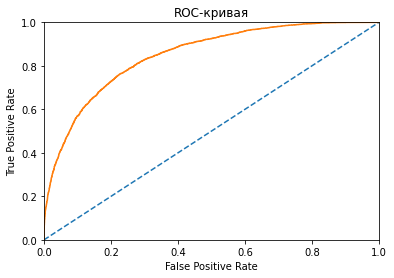

In [77]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Таким образом, максимальное значение f1 удалось достичь в модели с балансным весом классов. 

Проверка на тестовом датасете и подсчет прибыли с учетом модели

In [78]:
predictions = model_RF_balanced.predict(features_test_scaled)

print("F1:", f1_score(predictions, target_test))

Accuracy: 0.7270069987649238
F1: 0.5561282549032733


In [79]:
probabilities_test = model_RF_balanced.predict_proba(features_test_scaled)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(auc_roc)

0.7681483465925809


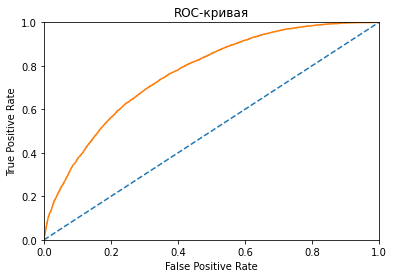

In [80]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [81]:
hotel_test_revenue['modeling'] = predictions

Составим две функции - первая посчитает возможную прибыль от внедрения нашей модели с учетом депозита 80%, а вторая - возможную прибыль от внедрения идеальной модели с учетом депозита 80%

In [82]:
def revenue_model(row):
    price = [value[0] for key, value in category.items() if key == row['reserved_room_type']]
    expense = [value[1] for key, value in category.items() if key == row['reserved_room_type']]
    cancel = row['modeling']
    total_nights = row['total_nights']
    season = row['season_margin']
    if cancel == 0:
        revenue =  int(''.join(map(str, price)))*total_nights*season - int(''.join(map(str, expense)))*math.ceil(total_nights/2)
    else:
        revenue = int(''.join(map(str, price)))*0.8*season-int(''.join(map(str, expense)))
        
    return revenue

hotel_test_revenue['revenue_model'] = hotel_test_revenue.apply(revenue_model, axis=1) 

def revenue_ideal_model(row):
    price = [value[0] for key, value in category.items() if key == row['reserved_room_type']]
    expense = [value[1] for key, value in category.items() if key == row['reserved_room_type']]
    cancel = row['is_canceled']
    total_nights = row['total_nights']
    season = row['season_margin']
    if cancel == 0:
        revenue =  int(''.join(map(str, price)))*total_nights*season - int(''.join(map(str, expense)))*math.ceil(total_nights/2)
    else:
        revenue = int(''.join(map(str, price)))*0.8*season-int(''.join(map(str, expense)))
        
    return revenue

hotel_test_revenue['revenue_model'] = hotel_test_revenue.apply(revenue_model, axis=1) 
hotel_test_revenue['revenue_ideal_model'] = hotel_test_revenue.apply(revenue_ideal_model, axis=1) 


In [83]:
revenue_test_set = hotel_test_revenue.groupby(['arrival_date_year']).agg({'revenue': 'sum'})
revenue_test_set_model = hotel_test_revenue.groupby(['arrival_date_year']).agg({'revenue_model': 'sum'})
revenue_test_set_ideal_model = hotel_test_revenue.groupby(['arrival_date_year']).agg({'revenue_ideal_model': 'sum'})
display(revenue_test_set)
display(revenue_test_set_ideal_model)
display(revenue_test_set_model)

,revenue
arrival_date_year,
2017,42163160.0


,revenue_ideal_model
arrival_date_year,
2017,48567128.0


,revenue_model
arrival_date_year,
2017,49346396.0


In [84]:
print(confusion_matrix(predictions, target_test))

[[13505  3527]
 [ 3104  4154]]


### Шаг 5. Опишите портрет «ненадёжного» клиента

Исходя из проведенного анализа данных мы видим, что отменяется примерно четверть всех бронирований. 

Чаще всего бронирования отменяют клиенты из азиатских и африканских стран, в то время как европейские клиенты более надежны.

Чаще других отменяются бронирования на 3 или 4 ночи, кроме того, большое количество отмен выпадает на клиентов путешествующих без детей, что может говорить о том, что клиенты, возможно, планируют остановиться в отеле во время рабочего визита. Можно порекомендовать заказчику добавить поле с выбором характера поездки - рабочая поездка или отпуск. 

Также мы видим рост числа отмен к лету и далее спад, и снова всплеск в декабре - можно объяснить сезонностью отпусков и поездками на новогодние каникулы. 

In [85]:
importances = model_RF_balanced.feature_importances_

feature_list = list(features_train_scaled.columns)

feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,lead_time,0.195245
1,required_car_parking_spaces,0.084808
2,total_of_special_requests,0.074917
3,arrival_date_week_number,0.059555
4,region_Southern Europe,0.054243
5,previous_cancellations,0.048252
6,arrival_date_day_of_month,0.045508
7,arrival_date_month,0.041266
8,customer_type_Transient,0.036759
9,region_Western Europe,0.034577


Мы провели оценку важности признаков, три наиболее значимых - количество дней между датой бронирования и датой прибытия, необходимость места для автомобиля и количество специальных отметок

### Шаг 6. Напишите общий вывод

1. Проведен анализ данных. Выявлен дисбаланс данных ~ 3 к 1.
2. Провели подготовку признаков используя методы OHE и масштабирования
3. Исселодвали модели на дисбалансных данных. Лучший результат показала модель Случайный лес. f1 = 0.54
4. Провели увеличение и уменьшение выборки. Метод увеличения оказался более эффективным. f1 = 0.63. Однако наибольшую эффективность показало использование балансного веса класса - f1 = 0.65
5. На тестовой выборке результат f1 составил 0.56. Показатель AUC-ROC = 0.77
6. Посчитали фактическую прибыль за неполный 2017 год - 42.1 млн руб. В случае, если клиент решит брать комиссию 80%, и введет модель, то в идельном случае, при котором модель на 100% угадывает факт отмены - то прибыль составила бы 48.6 млн руб. При внедрении нашей модели прибыль составит 49.3 млн руб. По условию задачи: На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за год. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании. Исходя из этого, мы можем говорить, что внедрение данной модели принесло бы выручку в размере 6.5 млн руб. Погрешность нашей модели в данном случае составила 1,6%. Таким образом, внедрение данной модели окупится за один год.